# Classification model.


*   Take the original training set and classify all questions as 0: Answerable or 1: Unanswerable.
*   Use Huggingface transformers: BertForSequenceClassification
*   Evaluate results



### Step 1: File set up. 

In [ ]:
#Mount my drive so that I can access the split training sets. 

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Download the SQUAD train and dev dataset

# I will need the full training set.  
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

# Still download the Dev set.
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2020-07-21 13:35:42--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  58.5MB/s    in 0.7s    

2020-07-21 13:35:46 (58.5 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2020-07-21 13:35:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

### Step 2: Set up GPU and HuggingFace

In [ ]:
# Connect to GPU
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla P100-PCIE-16GB


In [ ]:
#install transformers. 

!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 16.3MB/s 
     |████████████████████████████████| 1.1MB 35.7MB/s 
     |████████████████████████████████| 890kB 24.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=41061e3e6a520ed2ffd5b162bc5075152a31e3c28bb80abbf27a9fbb9b2192f4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Step 3: Create Dataset

In [ ]:
#Helper Functions

import json
import pandas as pd
import numpy as np

# Need a helper function to open each file
def open_json(path):
    with open(path) as json_file:
        temp_json = json.load(json_file)
        return temp_json

#this will be code if these are impossible or not. 
def extract_answer_type(file):
    data = open_json(file)
    impossible = [] #0 = Possible, 1 = Impossible.
    for i in range(len(data['data'])):
        paragraphs = len(data['data'][i]['paragraphs'])
        for j in range(paragraphs):
            qas = len(data['data'][i]['paragraphs'][j]['qas'])
            for k in range(qas):
                if data['data'][i]['paragraphs'][j]['qas'][k]['is_impossible'] == True:
                    impossible.append(1)
                else:
                    impossible.append(0)
    return impossible

#this will generate the question data
#This is done by combining the question and context.
def extract_question(file):
    data = open_json(file)
    text = []
    for i in range(len(data['data'])):
        paragraphs = len(data['data'][i]['paragraphs'])
        for j in range(paragraphs):
            context = data['data'][i]['paragraphs'][j]['context']
            qas = len(data['data'][i]['paragraphs'][j]['qas'])
            for k in range(qas):
                question_id = data['data'][i]['paragraphs'][j]['qas'][k]['id']
                question = data['data'][i]['paragraphs'][j]['qas'][k]['question']
                text.append([question_id, context, question])
    return text


In [ ]:
#create the labels. 
impossible = extract_answer_type('train-v2.0.json')
impossible_df = pd.DataFrame(impossible) 
impossible_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
#pull out question data 
question_text = extract_question('train-v2.0.json')
q_df = pd.DataFrame(question_text)
q_df.head()

,0,1,2
0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?
1,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...
2,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...
3,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?
4,56bf6b0f3aeaaa14008c9602,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?


In [ ]:
#combine into one data frame and save to CSV.
full_df = pd.concat([q_df, impossible_df], axis = 1, sort = False)
full_df.columns = ['id', 'context', 'question', 'impossible']
full_df.head()
full_df.to_csv('train_classification.csv')

In [ ]:
#bring a copy over into my drive so I can pick up here.

%cp -R /content/train_classification.csv /content/drive/My\ Drive/

In [ ]:
#if just picking back off:

full_df = pd.read_csv('/content/drive/My Drive/train_classification.csv')

In [ ]:
# ------ FOR A MINI TRAINING SET ------
# mini_df = full_df[:10000]

# # #Get the lists of sentences and their labels.
# contexts = mini_df.context.values
# questions = mini_df.question.values
# labels = mini_df.impossible.values

# ------ FOR THE FULL  TRAINING SET ------
contexts = full_df.context.values
questions = full_df.question.values
labels = full_df.impossible.values


print(labels.shape)

(130319,)


### Step 4: Tokenize the Text

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
#Because the question and answer are combined, this may result
#questions with greater than 512 tokens.

# max_len = 0
# for sent in contexts:
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)
#     max_len = max(max_len, len(input_ids))
# print('Max sentence length: ', max_len)

#Quite a few errors here:  I will have to take the input length to max and truncate. 


When did Beyonce start becoming popular?
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = []
attention_masks = []

#Add the question to the front of the contexts 
for i in range(len(questions)):
    text = (str(questions[i])+' '+str(contexts[i]))

    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Take to the max length
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',
                        truncation = True)

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
# print('Original: ', [0])
# print('Token IDs:', input_ids[0])

KeyboardInterrupt: ignored

In [ ]:
#save the embeddings since this takes a while to run. 

torch.save(input_ids, '/content/drive/My Drive/input_ids_512c.pt')
torch.save(attention_masks, '/content/drive/My Drive/attn_mask_512c.pt')
torch.save(labels, '/content/drive/My Drive/labels_512c.pt')

print(input_ids.shape)
print(attention_masks.shape)
print(labels.shape)


torch.Size([130319, 512])
torch.Size([130319, 512])
torch.Size([130319])


In [ ]:
#pick up here by loading them back from my drive. 
input_ids = torch.load('/content/drive/My Drive/input_ids_512c.pt')
attention_masks = torch.load('/content/drive/My Drive/attn_mask_512c.pt')
labels = torch.load('/content/drive/My Drive/labels_512c.pt')
#sanity check the shape.
print(input_ids.size(0))
print(attention_masks.size(0))
print(labels.size(0))



130319
130319
130319


In [ ]:
# Going to do some prevalidation so I can watch the training loss
# Before I run it on the dev set. 

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))




117,287 training samples
13,032 validation samples


In [ ]:
# Set Up data Loader 

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
#12 is the biggest batch I could get here on a 16GB GPU.
batch_size = 12
# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size)


### Step 5: Load model 

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Set optimizer 
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon  
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Step 6: Training loop

In [ ]:
# Helper functions for training and timing.

import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Format as hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# memory footprint support libraries/code
# this is to check to see what my memory looks like since 
# memory issues tend to cause this whole thing to crash. 

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8371ad299b82d8a3b25759b229f315337a4098a67b064a33b64d1a457cbb373b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 24.2 GB  |     Proc size: 4.3 GB
GPU RAM Free: 15015MB | Used: 1265MB | Util   8% | Total     16280MB


In [ ]:
#full training loop

import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels = b_labels)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 2 ========
Training...
  Batch    40  of  9,774.    Elapsed: 0:00:26.
  Batch    80  of  9,774.    Elapsed: 0:00:52.
  Batch   120  of  9,774.    Elapsed: 0:01:17.
  Batch   160  of  9,774.    Elapsed: 0:01:43.
  Batch   200  of  9,774.    Elapsed: 0:02:09.
  Batch   240  of  9,774.    Elapsed: 0:02:35.
  Batch   280  of  9,774.    Elapsed: 0:03:00.
  Batch   320  of  9,774.    Elapsed: 0:03:26.
  Batch   360  of  9,774.    Elapsed: 0:03:52.
  Batch   400  of  9,774.    Elapsed: 0:04:18.
  Batch   440  of  9,774.    Elapsed: 0:04:43.
  Batch   480  of  9,774.    Elapsed: 0:05:09.
  Batch   520  of  9,774.    Elapsed: 0:05:35.
  Batch   560  of  9,774.    Elapsed: 0:06:01.
  Batch   600  of  9,774.    Elapsed: 0:06:26.
  Batch   640  of  9,774.    Elapsed: 0:06:52.
  Batch   680  of  9,774.    Elapsed: 0:07:18.
  Batch   720  of  9,774.    Elapsed: 0:07:44.
  Batch   760  of  9,774.    Elapsed: 0:08:09.
  Batch   800  of  9,774.    Elapsed: 0:08:35.
  Batch   840  of 

### Step 7: Visualize Training Results

In [ ]:
#Make a dataframe of results. 

# Display floats with two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.44,0.36,0.83,1:44:53,0:03:46
2,0.30,0.37,0.84,1:44:52,0:03:45


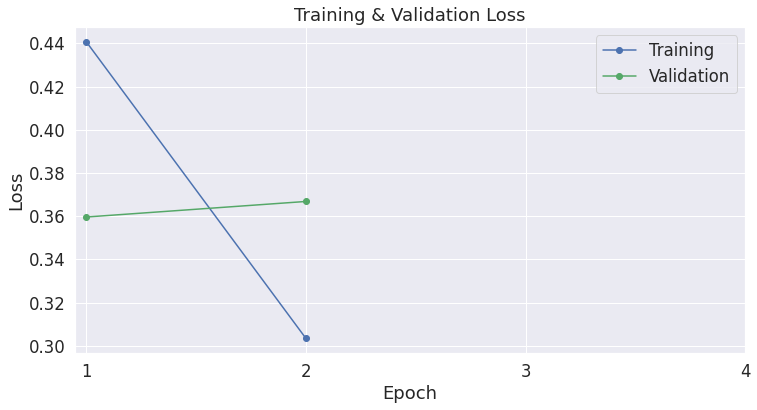

In [ ]:
#Plot the results from the Dataframe
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Step 8: Prep Dev Set


In [ ]:
import pandas as pd

#create the labels. 
d_impossible = extract_answer_type('dev-v2.0.json')
d_impossible_df = pd.DataFrame(d_impossible) 
d_impossible_df.head()

#pull out question data 
dq_text = extract_question('dev-v2.0.json')
dq_df = pd.DataFrame(dq_text)
dq_df.head()

# #import Dev set. 
# dev_df = pd.read_csv('dev_with_split.csv')
# #the empty choice is converted to a NaN when I reload, so this will correct the issue.
# dev_df['a'].fillna("", inplace=True)

# print('Number of dev sentences: {:,}\n'.format(dev_df.shape[0]))

,0,1,2
0,56ddde6b9a695914005b9628,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?
1,56ddde6b9a695914005b9629,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?
2,56ddde6b9a695914005b962a,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?
3,56ddde6b9a695914005b962b,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?
4,56ddde6b9a695914005b962c,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...


In [ ]:
#combine into one data frame and save to CSV.
dev_df = pd.concat([dq_df, d_impossible_df], axis = 1, sort = False)
dev_df.columns = ['id', 'context', 'question', 'impossible']
dev_df.head()
dev_df.to_csv('dev_classification.csv')

In [ ]:
#bring a copy over into my drive so I can pick up here.

%cp -R /content/dev_classification.csv /content/drive/My\ Drive/

In [ ]:
#if just picking back off:

dev_df = pd.read_csv('/content/drive/My Drive/dev_classification.csv')

In [ ]:
#pull out the relevant columns.

contexts = dev_df.context.values
questions = dev_df.question.values
labels = dev_df.impossible.values


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = []
attention_masks = []

#Add the question to the front of the contexts 
for i in range(len(questions)):
    text = (str(questions[i])+' '+str(contexts[i]))

    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Take to the max length
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',
                        truncation = True)

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
# print('Original: ', [0])
# print('Token IDs:', input_ids[0])

In [ ]:
#Check the shape to make sure it worked correctly. 
print(input_ids.size(0))
print(attention_masks.size(0))
print(labels.size(0))

11873
11873
11873


In [ ]:
# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Step 9: Evaluate Dev Set


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 11,873 test sentences...
    DONE.


In [ ]:
#This will give me all 0's and 1's
def get_label_list(predictions):
  full_label_list = []
  for i in range(len(predictions)):
    for j in range(len(predictions[i])):
      full_label_list.append((np.argmax(predictions[i], axis=1).flatten())[j])
  return full_label_list

full_labels = get_label_list(predictions)

In [ ]:
# Necessary installs so I can mount the files from my bucket onto colab

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  29681      0 --:--:-- --:--:-- --:--:-- 29681
OK
66 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 66 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...


In [ ]:
# Make a folder for the bucket, this will have all of the files inside. 

!mkdir folderOnColab
!gcsfuse thaddeussegura_final_project folderOnColab 

Using mount point: /content/folderOnColab
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [ ]:
# def get_pred_dict(full_labels):
#     pred_dict = {}
#     for i in range(len(full_labels)):
#         key = str(dev_df['id'][i])
#         best_guess = str(dev_df.iloc[i, full_labels[i]])
#         pred_dict[key] = best_guess
#     return pred_dict 

def output_predictions(predictions):
    with open('preds.json', 'w', encoding = 'utf-8') as json_file:
        json.dump(predictions, json_file, ensure_ascii=True)

def apply_classification(full_labels):
  preds = open_json('predictions.json')
  for i, id in enumerate(preds):
    if full_labels[i] == 1:
      preds[id] = ""
  output_predictions(preds)

In [ ]:
apply_classification(full_labels)

In [ ]:
# save a copy in my drive.

%cp -R /content/preds.json /content/drive/My\ Drive/classification_save 

In [ ]:
# Clone SQUAD repo for the evaluation file.
# Move the eval file to my content folder 

!git clone https://github.com/white127/SQUAD-2.0-bidaf.git
%mv /content/SQUAD-2.0-bidaf/evaluate-v2.0.py /content/

Cloning into 'SQUAD-2.0-bidaf'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 709.51 KiB | 647.00 KiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
# Still download the Dev set.
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2020-07-21 18:15:08--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json.1’

dev-v2.0.json.1     100%[===================>]   4.17M  13.0MB/s    in 0.3s    

2020-07-21 18:15:08 (13.0 MB/s) - ‘dev-v2.0.json.1’ saved [4370528/4370528]



In [ ]:
print("Results for Classification")
!python evaluate-v2.0.py dev-v2.0.json preds.json


Results for Classification
{
  "exact": 75.36427187736882,
  "f1": 78.37238782818865,
  "total": 11873,
  "HasAns_exact": 70.58029689608637,
  "HasAns_f1": 76.60515531108051,
  "HasAns_total": 5928,
  "NoAns_exact": 80.13456686291,
  "NoAns_f1": 80.13456686291,
  "NoAns_total": 5945
}


### Step 10: Save Fine-Tuned Model 

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/classification_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(model.state_dict(), '/content/drive/My Drive/classification_save/model_state_dict.pth')
# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/My Drive/classification_save/


('/content/drive/My Drive/classification_save/vocab.txt',
 '/content/drive/My Drive/classification_save/special_tokens_map.json',
 '/content/drive/My Drive/classification_save/added_tokens.json')